# Titanic: Machine Learning from Disaster

## Problem Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.


In [1]:
# Import the required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# To display all the columns
pd.options.display.max_columns = None

# To display all the rows
pd.options.display.max_rows = None

# To map Empty Strings or numpy.inf as Na Values
pd.options.mode.use_inf_as_na = True

pd.options.display.expand_frame_repr =  False

%matplotlib inline

# Set Style
sns.set(style = "whitegrid")

# Data Import

In [2]:
# train data
titanic_data = pd.read_csv('train.csv', low_memory = False, skipinitialspace = True, float_precision = 2)

# data glimpse
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# test data
titanic_test_data = pd.read_csv('test.csv', low_memory = False, skipinitialspace = True, float_precision = 2)

# data glimpse
titanic_test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## VariableDefinitionKey 
    -- survival - Survival 0 = No, 1 = Yes 
    -- pclass - Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd 
    -- sex - Sex 
    -- Age - Age in years 
    -- sibsp - # of siblings / spouses aboard the Titanic parch # of parents / children aboard the Titanic 
    -- ticket - Ticket number 
    -- fare - Passenger fare 
    -- cabin - Cabin number 
    -- embarked - Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton 

## Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [4]:
print("Train Data Shape:", titanic_data.shape)
print("Test Data Shape:", titanic_test_data.shape)

Train Data Shape: (891, 12)
Test Data Shape: (418, 11)


In [5]:
# train set columns
print("Columns in the train set :")
print(titanic_data.columns)

print('\n')

# test set columns
print("Columns in the test set :")
print(titanic_test_data.columns)

Columns in the train set :
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


Columns in the test set :
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


# Data Exploraton and Preparation

In [6]:
# the columns 'PassengerId' and 'Ticket' willl be of no value in the analysis.
# Lets drop those columns from both the train ans test set.

# train set
titanic_data.drop(columns = ['PassengerId', 'Ticket'], axis = 1, inplace = True)

# test set
titanic_test_passengerId = titanic_test_data[['PassengerId']]
titanic_test_data.drop(columns = ['PassengerId', 'Ticket'], axis = 1, inplace = True)

# data glimpse
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [7]:
# Check the total missing values in each column.
print("Total NULL Values in each columns")
print("*********************************")
print(titanic_data.isnull().sum())

Total NULL Values in each columns
*********************************
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


In [8]:
# Lets check the percentage of missing values column-wise in the train data

(titanic_data.isnull().sum()/ len(titanic_data)) * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

#### We see in the train set - 
1. 'Age' column has 19.86% missing values 
2. 'Cabin' column has 77.10% missing values 
3. 'Embarked' column has 0.22% missing values

#### Let's check the same for the test set

In [9]:
# Lets check the percentage of missing values column-wise in the test data

(titanic_test_data.isnull().sum()/ len(titanic_test_data)) * 100

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         20.574163
SibSp        0.000000
Parch        0.000000
Fare         0.239234
Cabin       78.229665
Embarked     0.000000
dtype: float64

#### We see in the train set - 
1. 'Age' column has 20.57% missing values 
2. 'Cabin' column has 78.22% missing values 

#### Let's seee how we can handle the missing values here

In [10]:
# With more than 75% of values missing, we can drop the column - 'Cabin' but before doing that let us have a look 
# at it if we can get something out of almost nothing - 

titanic_data.Cabin.value_counts()

B96 B98            4
C23 C25 C27        4
G6                 4
F2                 3
F33                3
C22 C26            3
D                  3
E101               3
E33                2
C52                2
C126               2
C125               2
B28                2
E8                 2
F4                 2
D35                2
D33                2
B58 B60            2
C68                2
D20                2
B20                2
B22                2
B51 B53 B55        2
C124               2
E121               2
B18                2
B57 B59 B63 B66    2
C83                2
F G73              2
C123               2
E67                2
D26                2
C93                2
B49                2
E25                2
B35                2
D36                2
C78                2
C2                 2
C65                2
E24                2
E44                2
B77                2
D17                2
B5                 2
C92                2
B38                1
C82          

In [11]:
titanic_test_data.Cabin.value_counts()

B57 B59 B63 B66    3
C31                2
C116               2
B45                2
A34                2
C78                2
C6                 2
C23 C25 C27        2
C89                2
F4                 2
C101               2
C55 C57            2
E34                2
C80                2
B24                1
D10 D12            1
C28                1
D43                1
B10                1
D                  1
F2                 1
A29                1
C54                1
C39                1
G6                 1
C53                1
D19                1
C130               1
B58 B60            1
D22                1
D37                1
B52 B54 B56        1
D30                1
F                  1
B51 B53 B55        1
E50                1
F E57              1
C97                1
B61                1
C85                1
B69                1
C106               1
A21                1
D40                1
A9                 1
A18                1
E52                1
D34          

In [12]:
# Observations from the above cell - 
# 1. We see above that there are about 147 unique values and some rows have multiple cabins allocated.

# 2. Each cabin has 2 parts. Digging into the cabin numbers in the titanic, wikipedia shows the first letter
#    in the cabin is the Deck and the number is the room number.

# We will extract the deck information from the cabin

titanic_data["deck"] = titanic_data["Cabin"].str.slice(0,1)

titanic_test_data["deck"] = titanic_test_data["Cabin"].str.slice(0,1)

# data glimpse
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,NaN
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,NaN
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,NaN


In [13]:
# Lets now check the value counts for the newly created column - 'deck'

print('Deck Value Counts for train set - ')
print(titanic_data.deck.value_counts())

print('\n')

print('Deck Value Counts for test set - ')
print(titanic_test_data.deck.value_counts())

Deck Value Counts for train set - 
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: deck, dtype: int64


Deck Value Counts for test set - 
C    35
B    18
D    13
E     9
F     8
A     7
G     1
Name: deck, dtype: int64


In [14]:
# Lets assign a default deck - say 'Z' for both the train and the test sets -

# train set
titanic_data["deck"] = titanic_data["deck"].fillna("Z")

# also replace the single T-deck with G
titanic_data['deck'].replace(['T'], ['G'], inplace=True)

# test set
titanic_test_data["deck"] = titanic_test_data["deck"].fillna("Z")

# data glimpse
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,Z
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,Z
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,Z


In [15]:
# Now we have the deck information, We can drop the cabin column

# train set
titanic_data.drop(columns = ['Cabin'], axis = 1, inplace = True)

# test set
titanic_test_data.drop(columns = ['Cabin'], axis = 1, inplace = True)

# data glimpse
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Z
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Z
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Z


In [16]:
# Let's have a look at the age values wrt -
# 1. gender
# 2. salutation (in the name column every person has a salutaion prefix. This can be a factor in
# imputing the missing age values)

# lets check the gender wise age distribution in the train set

print('Train Set')
print('Age of the oldest Passenger was:', titanic_data['Age'].max(),'Years')
print('Age of the youngest Passenger was:', titanic_data['Age'].min(),'Years')
print('Average Age on the ship:', titanic_data['Age'].mean(),'Years\n')

print(titanic_data.groupby(by = ['Sex']).Age.describe())

print('\n-----------------------------------------------------------------------------\n')
print('Test Set')
# lets check the gender wise age distribution in the test set

print('Age of the oldest Passenger was:', titanic_test_data['Age'].max(),'Years')
print('Age of the youngest Passenger was:', titanic_test_data['Age'].min(),'Years')
print('Average Age on the ship:', titanic_test_data['Age'].mean(),'Years\n')

print(titanic_test_data.groupby(by = ['Sex']).Age.describe())


Train Set
Age of the oldest Passenger was: 80.0 Years
Age of the youngest Passenger was: 0.42 Years
Average Age on the ship: 29.69911764705882 Years

        count       mean        std   min   25%   50%   75%   max
Sex                                                              
female  261.0  27.915709  14.110146  0.75  18.0  27.0  37.0  63.0
male    453.0  30.726645  14.678201  0.42  21.0  29.0  39.0  80.0

-----------------------------------------------------------------------------

Test Set
Age of the oldest Passenger was: 76.0 Years
Age of the youngest Passenger was: 0.17 Years
Average Age on the ship: 30.272590361445783 Years

        count       mean        std   min   25%   50%   75%   max
Sex                                                              
female  127.0  30.272362  15.428613  0.17  20.5  27.0  38.5  76.0
male    205.0  30.272732  13.389528  0.33  22.0  27.0  40.0  67.0


In [17]:
# 2. salutation (in the name column every person has a salutaion prefix. This can be a factor in
# imputing the missing age values)

# We will extract the salution from every person's name in the Name column.

salutation = titanic_data.Name.str.split(', ').str[1].str.split('.').str[0]
titanic_data['salutation'] = salutation
titanic_data.salutation.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Sir               1
the Countess      1
Capt              1
Jonkheer          1
Lady              1
Don               1
Ms                1
Mme               1
Name: salutation, dtype: int64

In [18]:
# applying the above in the test set to extract the salutation there -

salutation = titanic_test_data.Name.str.split(', ').str[1].str.split('.').str[0]
titanic_test_data['salutation'] = salutation
titanic_test_data.salutation.value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Ms          1
Dona        1
Dr          1
Name: salutation, dtype: int64

### Salutations Data Dictionary

    -- Mlle         - unmarried woman - Mademoiselle
    -- Mme          - older married woman - Madame
    -- countess     - the wife or widow of a count or earl
    -- Jonkheer     - jonkvrouw is literally translated as "young lord" or "young lady"
    -- Rev          - The Most Reverend is a style applied to certain religious figures, primarily within the 
                      historic   denominations of Christianity, but occasionally in some more modern traditions also.

**The above data is taken from respective wikipedia or from results returned by google.**

Going by the above meanings of the salutations, we can combine some of the salutations to one.

    -- Mlle, Jonkheer, Ms and Miss can be replaced with 'Miss'
    -- Mme, countess, Lady and Mrs can be replaced with 'Mrs'
    -- Sir can be replaced with 'Mr'
    -- Rest of the salutations will be treated as is
    -- Major, Col, Capt can be replaced with a common term - 'army_rank'

In [19]:
# Salutations inputations in train data

titanic_data['salutation'].replace(['Mme','Lady','the Countess','Jonkheer'], ['Mrs','Mrs', 'Mrs','Mrs'], inplace=True)

titanic_data['salutation'].replace(['Mlle', 'Jonkheer', 'Ms' ], ['Miss','Miss', 'Miss'], inplace=True)

titanic_data['salutation'].replace(['Sir'], ['Mr'], inplace=True)

titanic_data['salutation'].replace(['Major', 'Col', 'Capt'], ['army_rank', 'army_rank', 'army_rank'], inplace=True)

In [20]:
# age distribution with respect to the name salutations

print(titanic_data.groupby(by = ['salutation']).Age.describe())

            count       mean        std    min    25%   50%    75%   max
salutation                                                              
Don           1.0  40.000000        NaN  40.00  40.00  40.0  40.00  40.0
Dr            6.0  42.000000  12.016655  23.00  35.00  46.5  49.75  54.0
Master       36.0   4.574167   3.619872   0.42   1.00   3.5   8.00  12.0
Miss        149.0  21.845638  12.870542   0.75  14.50  21.0  30.00  63.0
Mr          399.0  32.409774  12.720098  11.00  23.00  30.0  39.00  80.0
Mrs         112.0  35.892857  11.345799  14.00  27.75  35.0  44.00  63.0
Rev           6.0  43.166667  13.136463  27.00  31.50  46.5  53.25  57.0
army_rank     5.0  56.600000   9.316652  45.00  52.00  56.0  60.00  70.0


In [21]:
# Salutations inputations in test data

titanic_test_data['salutation'].replace(['Mme','Lady','the Countess','Jonkheer'], ['Mrs','Mrs', 'Mrs','Mrs'], inplace=True)

titanic_test_data['salutation'].replace(['Mlle', 'Jonkheer', 'Ms' ], ['Miss','Miss', 'Miss'], inplace=True)

titanic_test_data['salutation'].replace(['Sir'], ['Mr'], inplace=True)

titanic_test_data['salutation'].replace(['Major', 'Col', 'Capt'], ['army_rank', 'army_rank', 'army_rank'], inplace=True)

titanic_test_data['salutation'].replace(['Dona'], ['Don'], inplace=True)

In [22]:
# age distribution with respect to the name salutations

print(titanic_test_data.groupby(by = ['salutation']).Age.describe())

            count       mean        std    min    25%   50%    75%   max
salutation                                                              
Don           1.0  39.000000        NaN  39.00  39.00  39.0  39.00  39.0
Dr            1.0  53.000000        NaN  53.00  53.00  53.0  53.00  53.0
Master       17.0   7.406471   4.672470   0.33   5.00   7.0  11.50  14.5
Miss         64.0  21.774844  10.457716   0.17  17.75  22.0  29.25  45.0
Mr          183.0  32.000000  11.804497  14.00  23.00  28.5  40.00  67.0
Mrs          62.0  38.903226  15.034070  16.00  26.00  36.5  49.50  76.0
Rev           2.0  35.500000   7.778175  30.00  32.75  35.5  38.25  41.0
army_rank     2.0  50.000000   4.242641  47.00  48.50  50.0  51.50  53.0


We have the age distributions for each salutation category. We will use this information to impute each of the missing age values with an appropriate value is the respective salutation category.

Lets check the number fo missing values in each of these categories - 

In [23]:
# Missing age value for each category - 

print('Number of presons with salutation type Mr having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Mr')].shape[0])

print('Number of presons with salutation type Capt having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Capt')].shape[0])

print('Number of presons with salutation type Col having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Col')].shape[0])

print('Number of presons with salutation type Don having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Don')].shape[0])

print('Number of presons with salutation type Dr having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Dr')].shape[0])

print('Number of presons with salutation type Major having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Major')].shape[0])

print('Number of presons with salutation type Master having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Master')].shape[0])

print('Number of presons with salutation type Miss having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Miss')].shape[0])

print('Number of presons with salutation type Mrs having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Mrs')].shape[0])

print('Number of presons with salutation type Rev having missing age value - ', 
      titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Rev')].shape[0])

Number of presons with salutation type Mr having missing age value -  119
Number of presons with salutation type Capt having missing age value -  0
Number of presons with salutation type Col having missing age value -  0
Number of presons with salutation type Don having missing age value -  0
Number of presons with salutation type Dr having missing age value -  1
Number of presons with salutation type Major having missing age value -  0
Number of presons with salutation type Master having missing age value -  4
Number of presons with salutation type Miss having missing age value -  36
Number of presons with salutation type Mrs having missing age value -  17
Number of presons with salutation type Rev having missing age value -  0


We see that only some category have missing age values. We will impute them with the following measures

    -- Salution type 'Mr' - Age can be imputed with the Median (as Mean > Median)
    -- Salution type 'Dr' - Age can be imputed with the Mean value
    -- Salution type 'Master' - Age can be imputed with the Median (as Mean > Median)
    -- Salution type 'Miss' - Age can be imputed with the Median (as Mean > Median)
    -- Salution type 'Mrs' - Age can be imputed with the Median (as Mean > Median)

In [24]:
# the values (mean & median) are taken from the - 'age distribution with respect to the name salutations' cell above.

titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Mr'),'Age'] = 30
titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Dr'),'Age'] = 42
titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Master'),'Age'] = 3.5
titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Miss'),'Age'] = 21
titanic_data.loc[(titanic_data['Age'].isnull()) & (titanic_data['salutation'] == 'Mrs'),'Age'] = 35

In [25]:
# Repeating the above for the test set as well -

# Missing age value for each category - 

print('Number of presons with salutation type Mr having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Mr')].shape[0])

print('Number of presons with salutation type Capt having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Capt')].shape[0])

print('Number of presons with salutation type Col having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Col')].shape[0])

print('Number of presons with salutation type Don having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Don')].shape[0])

print('Number of presons with salutation type Dr having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Dr')].shape[0])

print('Number of presons with salutation type Major having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Major')].shape[0])

print('Number of presons with salutation type Master having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Master')].shape[0])

print('Number of presons with salutation type Miss having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Miss')].shape[0])

print('Number of presons with salutation type Mrs having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Mrs')].shape[0])

print('Number of presons with salutation type Rev having missing age value - ', 
      titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Rev')].shape[0])

Number of presons with salutation type Mr having missing age value -  57
Number of presons with salutation type Capt having missing age value -  0
Number of presons with salutation type Col having missing age value -  0
Number of presons with salutation type Don having missing age value -  0
Number of presons with salutation type Dr having missing age value -  0
Number of presons with salutation type Major having missing age value -  0
Number of presons with salutation type Master having missing age value -  4
Number of presons with salutation type Miss having missing age value -  15
Number of presons with salutation type Mrs having missing age value -  10
Number of presons with salutation type Rev having missing age value -  0


In [26]:
# the values (mean & median) are taken from the - 'age distribution with respect to the name salutations' cell above.

titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Mr'),'Age'] = 28.5
titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Master'),'Age'] = 7
titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Miss'),'Age'] = 21.77
titanic_test_data.loc[(titanic_test_data['Age'].isnull()) & (titanic_test_data['salutation'] == 'Mrs'),'Age'] = 36.5

In [27]:
# Lets have a look at the percentage of null values in the data set now - 

(titanic_data.isnull().sum()/ len(titanic_data)) * 100

Survived      0.000000
Pclass        0.000000
Name          0.000000
Sex           0.000000
Age           0.000000
SibSp         0.000000
Parch         0.000000
Fare          0.000000
Embarked      0.224467
deck          0.000000
salutation    0.000000
dtype: float64

In [28]:
# Lets have a look at the percentage of null values in the data set now - 

(titanic_test_data.isnull().sum()/ len(titanic_test_data)) * 100

Pclass        0.000000
Name          0.000000
Sex           0.000000
Age           0.000000
SibSp         0.000000
Parch         0.000000
Fare          0.239234
Embarked      0.000000
deck          0.000000
salutation    0.000000
dtype: float64

In [29]:
# Now lets check on the missing values for the 'Embarked' column -

titanic_data.loc[(titanic_data['Embarked'].isnull())]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,deck,salutation
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN,B,Miss
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN,B,Mrs


So there are just 2 rows with misssing 'Embarked' - Port of Embarkation value. We will see some values near the fare amount for these 2 rows i.e., 80

In [30]:
titanic_data.loc[(titanic_data['Fare'] >= 79) & (titanic_data['Fare'] <= 82)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,deck,salutation
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0000,NaN,B,Miss
139,0,1,"Giglio, Mr. Victor",male,24.0,0,0,79.2000,C,B,Mr
256,1,1,"Thorne, Mrs. Gertrude Maybelle",female,35.0,0,0,79.2000,C,Z,Mrs
262,0,1,"Taussig, Mr. Emil",male,52.0,1,1,79.6500,S,E,Mr
445,1,1,"Dodge, Master. Washington",male,4.0,0,2,81.8583,S,A,Master
558,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,79.6500,S,E,Mrs
585,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,79.6500,S,E,Miss
587,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,79.2000,C,B,Mr
789,0,1,"Guggenheim, Mr. Benjamin",male,46.0,0,0,79.2000,C,B,Mr
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0000,NaN,B,Mrs


The above data shows that the 'Emabrked' values are C and S with almost equal distribution. Let us maintain this distribuion and impute C & S to each of the 2 missing embarked values.

In [31]:
titanic_data.loc[(titanic_data['Embarked'].isnull()) & (titanic_data['Age'] == 38),'Embarked'] = 'S'
titanic_data.loc[(titanic_data['Embarked'].isnull()) & (titanic_data['Age'] == 62),'Embarked'] = 'C'

In [32]:
# Lets have a look at the percentage of null values in the train set now - 

(titanic_data.isnull().sum()/ len(titanic_data)) * 100

Survived      0.0
Pclass        0.0
Name          0.0
Sex           0.0
Age           0.0
SibSp         0.0
Parch         0.0
Fare          0.0
Embarked      0.0
deck          0.0
salutation    0.0
dtype: float64

In [33]:
# the test set has some missing values in the fare column. lets examine that

titanic_test_data.Fare.describe()

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [34]:
# as mean > median value for Fare in test set, lets impute the missing value with median - 

# test set
titanic_test_data["Fare"] = titanic_test_data["Fare"].fillna(14.45)

In [35]:
# Lets have a look at the percentage of null values in the test set now - 

(titanic_test_data.isnull().sum()/ len(titanic_test_data)) * 100

Pclass        0.0
Name          0.0
Sex           0.0
Age           0.0
SibSp         0.0
Parch         0.0
Fare          0.0
Embarked      0.0
deck          0.0
salutation    0.0
dtype: float64

#### We have a perfectly clean data set now. There are still some columns like Name, Sex and salutation which need to be handled.

    -- Name column can be dropped.
    -- Sex column can be mapped to 1 - Female & 0 - Male (we will handle this column after the EDA section)
    -- salutation column can be one hot encoded. (we will handle this column after the EDA section)

In [36]:
# dropping the name column -

titanic_data.drop(['Name'], axis=1, inplace = True)
titanic_test_data.drop(['Name'], axis=1, inplace = True)

In [37]:
# data glimpse

titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,deck,salutation
0,0,3,male,22.0,1,0,7.2500,S,Z,Mr
1,1,1,female,38.0,1,0,71.2833,C,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Z,Miss
3,1,1,female,35.0,1,0,53.1000,S,C,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Z,Mr


In [38]:
# data glimpse

titanic_test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,deck,salutation
0,3,male,34.5,0,0,7.8292,Q,Z,Mr
1,3,female,47.0,1,0,7.0000,S,Z,Mrs
2,2,male,62.0,0,0,9.6875,Q,Z,Mr
3,3,male,27.0,0,0,8.6625,S,Z,Mr
4,3,female,22.0,1,1,12.2875,S,Z,Mrs


# Exploratory Data Analysis

#### Defining some custom functions for EDA graph plottting

In [39]:
# Custom Function for Default Plotting variables

# Function Parameters  - 

# figure_title         -    The title to use for the plot.
# xlabel               -    The x-axis label for the plot.
# ylabel               -    The y-axis label for the plot.
# xlabel_rotation      -    The degree of rotation for the x-axis ticks (values).
# legend_flag          -    Boolean flag to check if a legend is required to be their in the plot.
# legend               -    Place legend on axis subplots.

def set_plotting_variable(figure_title, xlabel, ylabel, xlabel_rotation, legend_flag, legend):
    
    plt.title(figure_title)
    plt.xticks(rotation = xlabel_rotation)
    plt.xlabel(xlabel, labelpad = 15)
    plt.ylabel(ylabel, labelpad = 10)
    
    if legend_flag == True:
        plt.legend(loc = legend)

In [40]:
# Function Parameters   -

# category              -      The category of the variable in consideration - Categorical or Continuous.
# plot_type             -      The type of the plot - Unordered Categorical (-lineplot) or Ordered Categorical (-countplot).
# series                -      The series/column from the data frame for which the univariate analysis is being considered for.
# figsize_x             -      The width of the plot figure in inches.
# figsize_y             -      The height of the plot figure in inches.
# subplot_x             -      The rows for the subplot.
# subplot_y             -      The columns for the subplot.
# xlabel                -      The x-axis label for the plot.
# ylabel                -      The y-axis label for the plot.
# x_axis                -      The series/variable to be plotted along the x-axis.
# hue                   -      The variable (categorical) in the data for which the plot is being considered for.
# data                  -      The data frame.
# legend                -      Place legend on axis subplots.

# hspace                -      The amount of height reserved for space between subplots,
#                              expressed as a fraction of the average axis height

# wspace                -      The amount of width reserved for space between subplots,
#                              expressed as a fraction of the average axis width

# xlabel_rotation       -      The degree of rotation for the x-axis ticks (values).

def plot_univariate(category, plot_type, series, figsize_x, figsize_y, subplot_x, subplot_y,
                    xlabel, ylabel, x_axis, hue, data, legend, hspace, wspace, xlabel_rotation):
    
    plt.figure(figsize = (figsize_x, figsize_y))
    
    if category == 'Categorical':
        
        title_1 = "Frequency Plot of " + xlabel
        title_2 = title_1 + " across Survival Status"
        
        # Subplot - 1
        plt.subplot(subplot_x, subplot_y, 1)
        
        if plot_type == 'Unordered Categorical':
            sns.lineplot(data = series)
        
        elif plot_type == 'Ordered Categorical':
            sns.countplot(x = x_axis, order = series.sort_index().index, data = data)
        
        # Call Custom Function
        set_plotting_variable(title_1, xlabel, ylabel, xlabel_rotation, False, legend)
        
        # Subplot - 2
        plt.subplot(subplot_x, subplot_y, 2)
        
        sns.countplot(x = x_axis, hue = hue, order = series.sort_index().index, data = data)
        # Call Custom Function
        set_plotting_variable(title_2, xlabel, ylabel, xlabel_rotation, True, legend)
    
    elif category == 'Continuous':
        
        title_1 = "Distribution Plot of " + xlabel
        title_2 = "Box Plot of " + xlabel
        title_3 = title_2 + " across Survival Status"
        
        # Subplot - 1
        plt.subplot(subplot_x, subplot_y, 1)
        
        sns.distplot(data[x_axis], hist = True, kde = True, color = 'g')
        # Call Custom Function
        set_plotting_variable(title_1, xlabel, ylabel, xlabel_rotation, False, legend)
        
        # Subplot - 2
        plt.subplot(subplot_x, subplot_y, 2)
        
        sns.boxplot(x = x_axis, data = data, color = 'm')
        # Call Custom Function
        set_plotting_variable(title_2, xlabel, ylabel, xlabel_rotation, False, legend)
           
    plt.subplots_adjust(hspace = hspace)
    plt.subplots_adjust(wspace = wspace)
    plt.show()

#### 1. Frequency plot for persons survived vs not survived

        -- 1 - Survived
        -- 0 - Not Survived

0    549
1    342
Name: Survived, dtype: int64




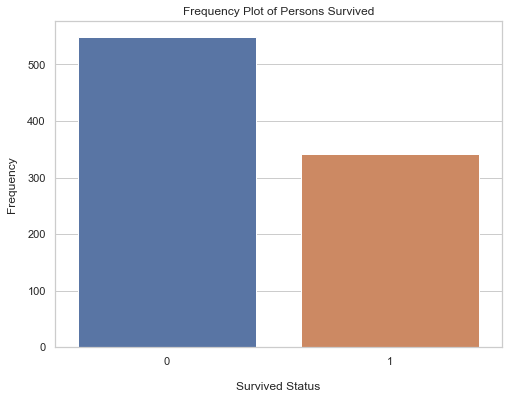

In [41]:
series = titanic_data.Survived.value_counts(dropna = False)

print(series.sort_index())
print('\n')

plt.figure(figsize = (8, 6))

plt.title('Frequency Plot of Persons Survived')
sns.countplot(x = 'Survived',  
              order = series.sort_index().index, 
              data = titanic_data)
plt.xlabel('Survived Status', labelpad = 15)
plt.ylabel('Frequency', labelpad = 10)

plt.subplots_adjust(wspace = 0.6)
plt.show()

# Survived - 1 means the person survived and 0 means the person did not survive the Titanic mishap.

#### 2. Port of Embarkation vs Survived Status

Embarked - Port of Embarkation
-------------------------------
C = Cherbourg 
Q = Queenstown 
S = Southampton
-------------------------------
C    169
Q     77
S    645
Name: Embarked, dtype: int64


Survived  Embarked
0         C            75
          Q            47
          S           427
1         C            94
          Q            30
          S           218
Name: Embarked, dtype: int64




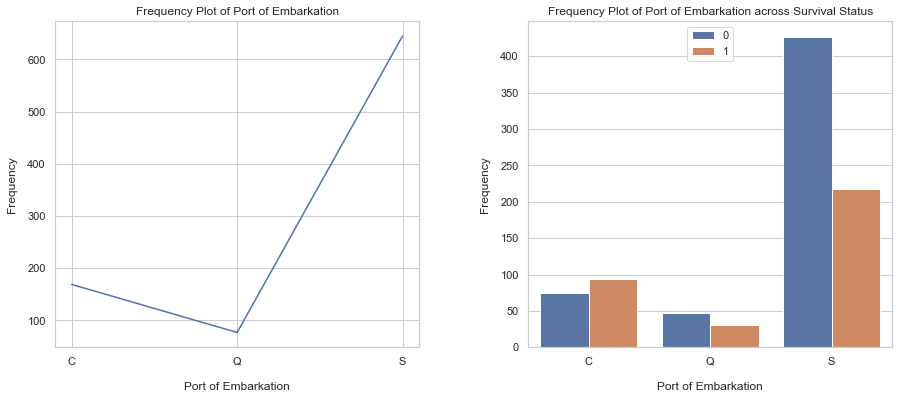

In [42]:
# Rank-Frequency Plot of Unordered Categorical Variable: Embarked

print('Embarked - ' + 'Port of Embarkation' + '\n' 
      +'-------------------------------' + '\n' + 'C = Cherbourg \nQ = Queenstown \nS = Southampton'  + '\n'
      +'-------------------------------')

series = titanic_data.Embarked.value_counts(dropna = False)

print(series.sort_index())
print('\n')
print(titanic_data.groupby(by = 'Survived').Embarked.value_counts(dropna = False).sort_index())
print('\n')

# Call Custom Function
plot_univariate(category = 'Categorical',
                plot_type = 'Unordered Categorical',
                series = series,
                figsize_x = 15,
                figsize_y = 6,
                subplot_x = 1,
                subplot_y = 2,
                xlabel = "Port of Embarkation",
                ylabel = "Frequency",
                x_axis = 'Embarked',
                hue = 'Survived',
                data = titanic_data,
                legend = 'upper center',
                hspace = 0,
                wspace = 0.3,
                xlabel_rotation = 0)

#### 3. Person Salutation v/s Survived Status 

Don            1
Dr             7
Master        40
Miss         185
Mr           518
Mrs          129
Rev            6
army_rank      5
Name: salutation, dtype: int64


Survived  salutation
0         Don             1
          Dr              4
          Master         17
          Miss           55
          Mr            436
          Mrs            27
          Rev             6
          army_rank       3
1         Dr              3
          Master         23
          Miss          130
          Mr             82
          Mrs           102
          army_rank       2
Name: salutation, dtype: int64




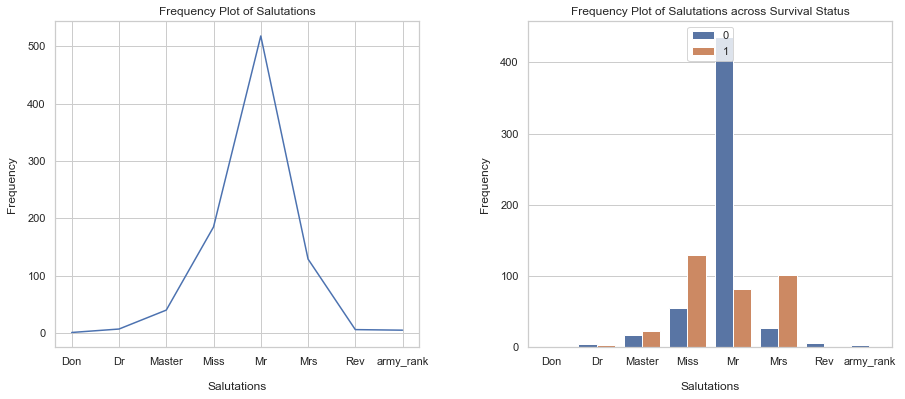

In [43]:
series = titanic_data.salutation.value_counts(dropna = False)

print(series.sort_index())
print('\n')
print(titanic_data.groupby(by = 'Survived').salutation.value_counts(dropna = False).sort_index())
print('\n')

# Call Custom Function
plot_univariate(category = 'Categorical',
                plot_type = 'Unordered Categorical',
                series = series,
                figsize_x = 15,
                figsize_y = 6,
                subplot_x = 1,
                subplot_y = 2,
                xlabel = "Salutations",
                ylabel = "Frequency",
                x_axis = 'salutation',
                hue = 'Survived',
                data = titanic_data,
                legend = 'upper center',
                hspace = 0,
                wspace = 0.3,
                xlabel_rotation = 0)

#### 4. Passenger Class vs Survived Status

Pclass - Passenger Class
-------------------------------
Ticket class 
1 = 1st 
2 = 2nd 
3 = 3rd
-------------------------------
1    216
2    184
3    491
Name: Pclass, dtype: int64


Survived  Pclass
0         1          80
          2          97
          3         372
1         1         136
          2          87
          3         119
Name: Pclass, dtype: int64




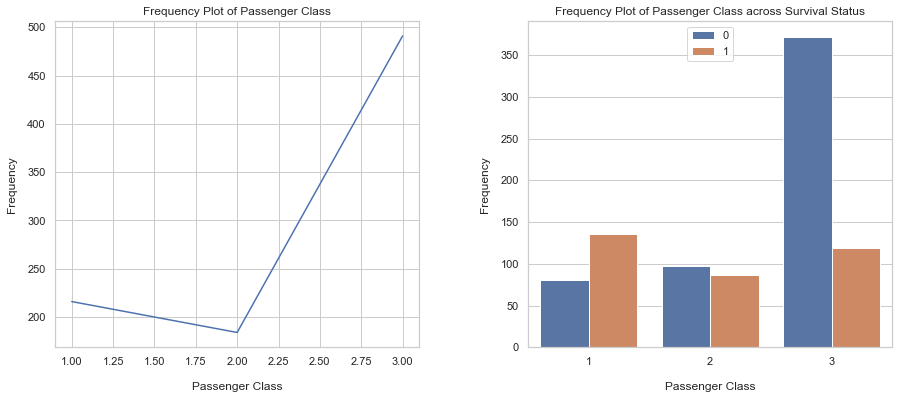

In [44]:
print('Pclass - ' + 'Passenger Class' + '\n' 
      +'-------------------------------' + '\n' + 'Ticket class \n1 = 1st \n2 = 2nd \n3 = 3rd' + '\n'
      +'-------------------------------')

series = titanic_data.Pclass.value_counts(dropna = False)

print(series.sort_index())
print('\n')
print(titanic_data.groupby(by = 'Survived').Pclass.value_counts(dropna = False).sort_index())
print('\n')

# Call Custom Function
plot_univariate(category = 'Categorical',
                plot_type = 'Unordered Categorical',
                series = series,
                figsize_x = 15,
                figsize_y = 6,
                subplot_x = 1,
                subplot_y = 2,
                xlabel = "Passenger Class",
                ylabel = "Frequency",
                x_axis = 'Pclass',
                hue = 'Survived',
                data = titanic_data,
                legend = 'upper center',
                hspace = 0,
                wspace = 0.3,
                xlabel_rotation = 0)

#### 5. Gender vs Survival Status

female    314
male      577
Name: Sex, dtype: int64


Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Sex, dtype: int64




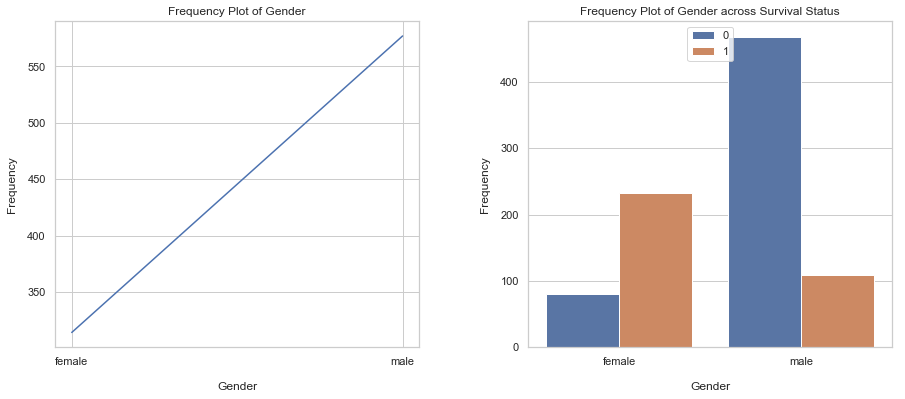

In [45]:
series = titanic_data.Sex.value_counts(dropna = False)

print(series.sort_index())
print('\n')
print(titanic_data.groupby(by = 'Survived').Sex.value_counts(dropna = False).sort_index())
print('\n')

# Call Custom Function
plot_univariate(category = 'Categorical',
                plot_type = 'Unordered Categorical',
                series = series,
                figsize_x = 15,
                figsize_y = 6,
                subplot_x = 1,
                subplot_y = 2,
                xlabel = "Gender",
                ylabel = "Frequency",
                x_axis = 'Sex',
                hue = 'Survived',
                data = titanic_data,
                legend = 'upper center',
                hspace = 0,
                wspace = 0.3,
                xlabel_rotation = 0)

#### 6. Gender, Survived vs Pclass

Sex     Survived  Pclass
female  0         1           3
                  2           6
                  3          72
        1         1          91
                  2          70
                  3          72
male    0         1          77
                  2          91
                  3         300
        1         1          45
                  2          17
                  3          47
Name: Pclass, dtype: int64


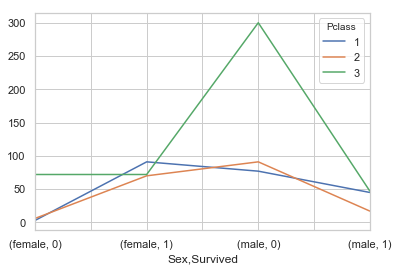

In [46]:
abc = titanic_data.groupby(['Sex', 'Survived']).Pclass.value_counts(dropna = False).sort_index()
print(abc)

abc.unstack().plot()

#### 7. Ticket Fare Distribution

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


          count       mean        std  min      25%   50%   75%       max
Survived                                                                 
0         549.0  22.117887  31.388207  0.0   7.8542  10.5  26.0  263.0000
1         342.0  48.395408  66.596998  0.0  12.4750  26.0  57.0  512.3292




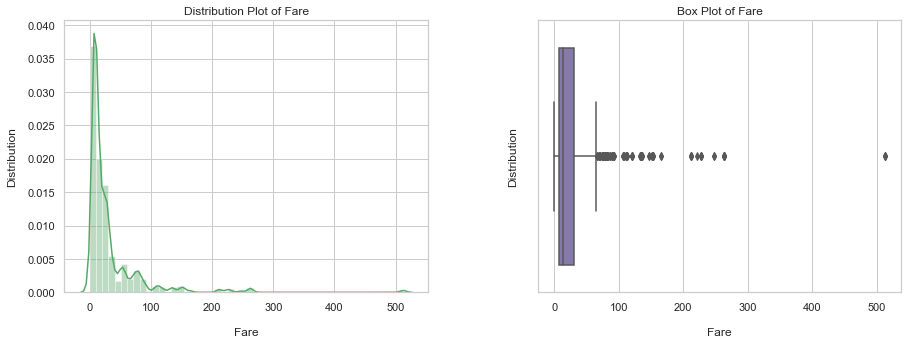

In [47]:
print(titanic_data.Fare.describe())
print('\n')
print(titanic_data.groupby(by = 'Survived').Fare.describe().sort_index())
print('\n')

# Call Custom Function
plot_univariate(category = 'Continuous',
                plot_type = 'Quantitative',
                series = [1, 0],
                figsize_x = 15,
                figsize_y = 12,
                subplot_x = 2,
                subplot_y = 2,
                xlabel = "Fare",
                ylabel = "Distribution",
                x_axis = 'Fare',
                hue = 'Survived',
                data = titanic_data,
                legend = 'best',
                hspace = 0.4,
                wspace = 0.3,
                xlabel_rotation = 0)

#### 8. Age vs Survived Status

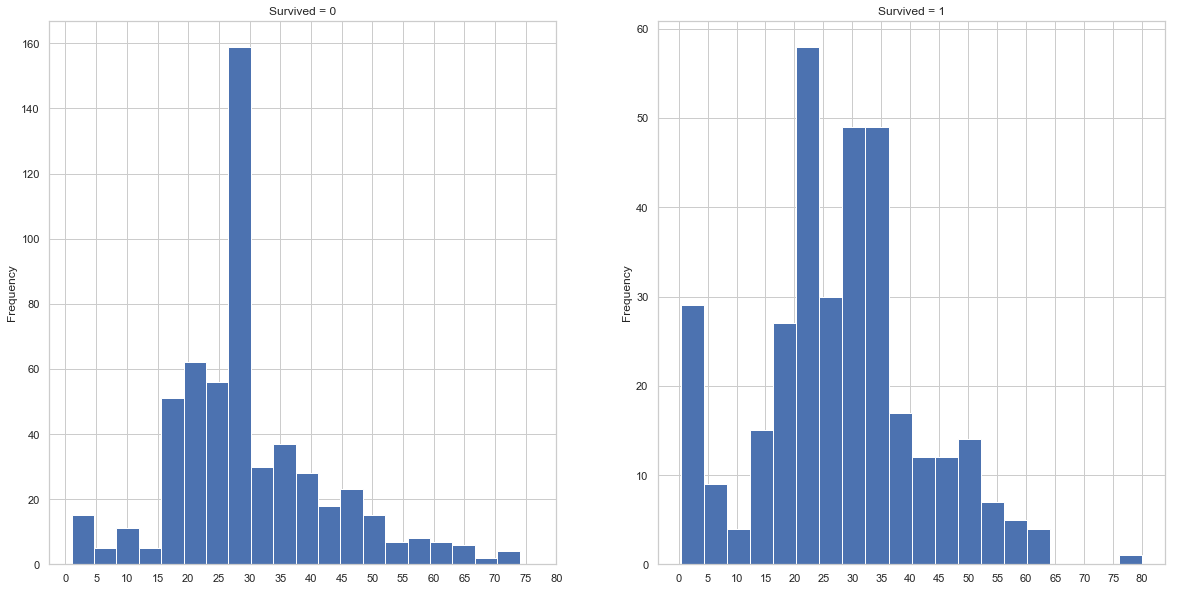

In [48]:
f,sub_plt = plt.subplots(1,2,figsize=(20,10))
x_bins = list(range(0,85,5))

# Survived Status 0
titanic_data[titanic_data['Survived'] == 0].Age.plot.hist(ax=sub_plt[0], bins=20)
sub_plt[0].set_title('Survived = 0')
sub_plt[0].set_xticks(x_bins)

# Survived Status 1
titanic_data[titanic_data['Survived'] == 1].Age.plot.hist(ax=sub_plt[1], bins=20)
sub_plt[1].set_title('Survived = 1')
sub_plt[1].set_xticks(x_bins)

plt.show()

#### 9. SibSp vs Survived Status

Survived  SibSp
0         0        398
          1         97
          2         15
          3         12
          4         15
          5          5
          8          7
1         0        210
          1        112
          2         13
          3          4
          4          3
Name: SibSp, dtype: int64


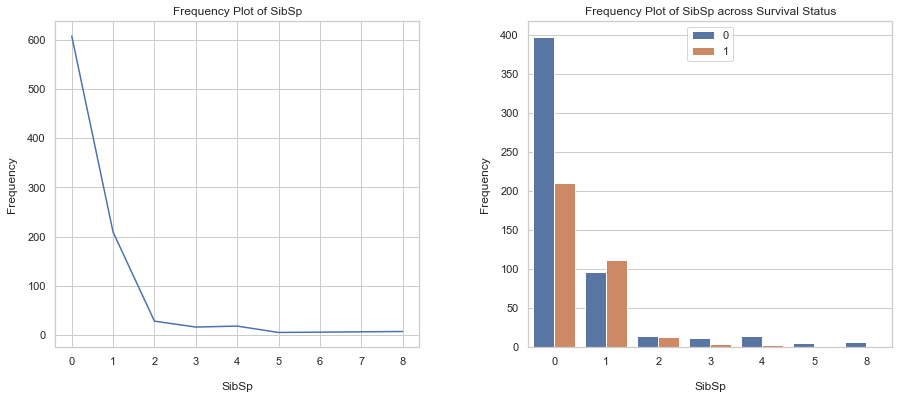

In [49]:
print(titanic_data.groupby(by = 'Survived').SibSp.value_counts(dropna = False).sort_index())

series = titanic_data.SibSp.value_counts(dropna = False)

plot_univariate(category = 'Categorical',
                plot_type = 'Unordered Categorical',
                series = series,
                figsize_x = 15,
                figsize_y = 6,
                subplot_x = 1,
                subplot_y = 2,
                xlabel = "SibSp",
                ylabel = "Frequency",
                x_axis = 'SibSp',
                hue = 'Survived',
                data = titanic_data,
                legend = 'upper center',
                hspace = 0,
                wspace = 0.3,
                xlabel_rotation = 0)

#### 10. Parch vs Survived Status

Survived  Parch
0         0        445
          1         53
          2         40
          3          2
          4          4
          5          4
          6          1
1         0        233
          1         65
          2         40
          3          3
          5          1
Name: Parch, dtype: int64


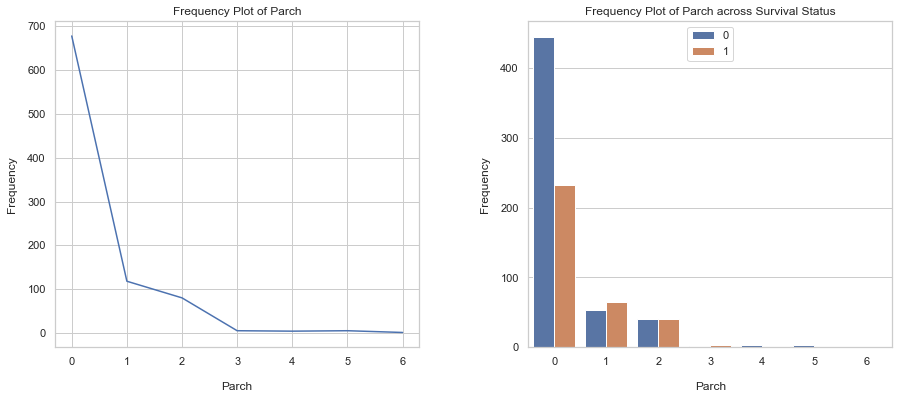

In [50]:
print(titanic_data.groupby(by = 'Survived').Parch.value_counts(dropna = False).sort_index())

series = titanic_data.Parch.value_counts(dropna = False)

plot_univariate(category = 'Categorical',
                plot_type = 'Unordered Categorical',
                series = series,
                figsize_x = 15,
                figsize_y = 6,
                subplot_x = 1,
                subplot_y = 2,
                xlabel = "Parch",
                ylabel = "Frequency",
                x_axis = 'Parch',
                hue = 'Survived',
                data = titanic_data,
                legend = 'upper center',
                hspace = 0,
                wspace = 0.3,
                xlabel_rotation = 0)

## Feature Engineering

### 1. familysize

**The two features - 'Prach' and 'SibSp' can be combined to get total family size. We will create a new variable 'familysize' adding these two features.**

In [51]:
# creation of the new feature - familysize
titanic_data['familysize'] = titanic_data['SibSp'] + titanic_data['Parch']

titanic_test_data['familysize'] = titanic_test_data['SibSp'] + titanic_test_data['Parch']

# lets now drop thae columns 'SibSp' and 'Parch' as they would be correlated and predict the 'familysize'

# train set
titanic_data.drop(columns = ['SibSp', 'Parch'], axis = 1, inplace = True)

# test set
titanic_test_data.drop(columns = ['SibSp', 'Parch'], axis = 1, inplace = True)

# data glimpse
titanic_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,deck,salutation,familysize
0,0,3,male,22.0,7.2500,S,Z,Mr,1
1,1,1,female,38.0,71.2833,C,C,Mrs,1
2,1,3,female,26.0,7.9250,S,Z,Miss,0
3,1,1,female,35.0,53.1000,S,C,Mrs,1
4,0,3,male,35.0,8.0500,S,Z,Mr,0


In [52]:
titanic_data['familysize'].describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: familysize, dtype: float64

**Lets now see how this new feature 'familysize' relates to the survived status**

#### Plotting familysize vs survival status

Survived  familysize
0         0             374
          1              72
          2              43
          3               8
          4              12
          5              19
          6               8
          7               6
          10              7
1         0             163
          1              89
          2              59
          3              21
          4               3
          5               3
          6               4
Name: familysize, dtype: int64


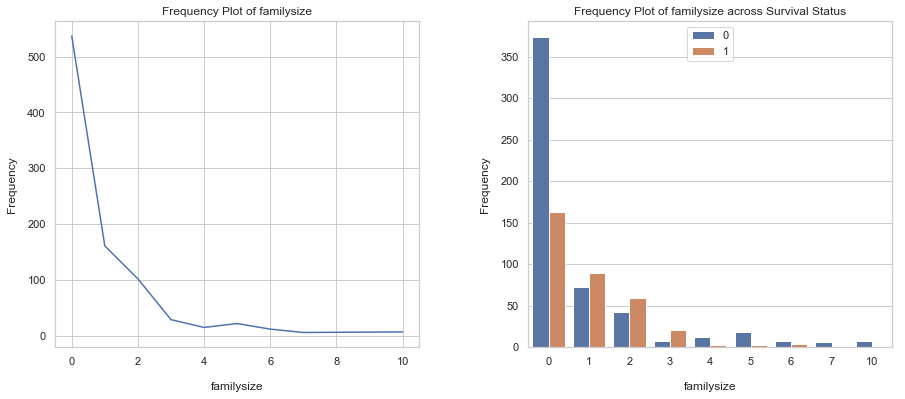

In [53]:
print(titanic_data.groupby(by = 'Survived').familysize.value_counts(dropna = False).sort_index())

series = titanic_data.familysize.value_counts(dropna = False)

plot_univariate(category = 'Categorical',
                plot_type = 'Unordered Categorical',
                series = series,
                figsize_x = 15,
                figsize_y = 6,
                subplot_x = 1,
                subplot_y = 2,
                xlabel = "familysize",
                ylabel = "Frequency",
                x_axis = 'familysize',
                hue = 'Survived',
                data = titanic_data,
                legend = 'upper center',
                hspace = 0,
                wspace = 0.3,
                xlabel_rotation = 0)

### 2. age_category

**Converting Age into bins (as it is continuos with no proper distribution)** 
**We will define a new variable  - age_category and have the following bins to categorize the person based on the age -**

    -- Age <= 15             -- age_category - 0
    -- Age > 15 & <= 30      -- age_category - 1
    -- Age > 30 & <= 45      -- age_category - 2
    -- Age > 45 & <= 60      -- age_category - 3
    -- Age > 60              -- age_category - 4

**As we have a new feature for age, we will drop the original Age feature as it would be redundant now**

In [54]:
# train set

titanic_data['age_category'] = 0
titanic_data.loc[titanic_data['Age'] <= 15,'age_category'] = 0
titanic_data.loc[(titanic_data['Age'] > 15) & (titanic_data['Age'] <= 30),'age_category'] = 1
titanic_data.loc[(titanic_data['Age'] > 30) & (titanic_data['Age'] <= 45),'age_category'] = 2
titanic_data.loc[(titanic_data['Age'] > 45) & (titanic_data['Age'] <= 60),'age_category'] = 3
titanic_data.loc[(titanic_data['Age'] > 60),'age_category'] = 4

# dropping the 'Age' feature
titanic_data.drop(['Age'], axis = 1, inplace = True)

# data glimpse
titanic_data.head()

,Survived,Pclass,Sex,Fare,Embarked,deck,salutation,familysize,age_category
0,0,3,male,7.2500,S,Z,Mr,1,1
1,1,1,female,71.2833,C,C,Mrs,1,2
2,1,3,female,7.9250,S,Z,Miss,0,1
3,1,1,female,53.1000,S,C,Mrs,1,2
4,0,3,male,8.0500,S,Z,Mr,0,2


In [55]:
# test set

titanic_test_data['age_category'] = 0
titanic_test_data.loc[titanic_test_data['Age'] <= 15,'age_category'] = 0
titanic_test_data.loc[(titanic_test_data['Age'] > 15) & (titanic_test_data['Age'] <= 30),'age_category'] = 1
titanic_test_data.loc[(titanic_test_data['Age'] > 30) & (titanic_test_data['Age'] <= 45),'age_category'] = 2
titanic_test_data.loc[(titanic_test_data['Age'] > 45) & (titanic_test_data['Age'] <= 60),'age_category'] = 3
titanic_test_data.loc[(titanic_test_data['Age'] > 60),'age_category'] = 4

# dropping the 'Age' feature
titanic_test_data.drop(['Age'], axis = 1, inplace = True)

# data glimpse
titanic_test_data.head()

,Pclass,Sex,Fare,Embarked,deck,salutation,familysize,age_category
0,3,male,7.8292,Q,Z,Mr,0,2
1,3,female,7.0000,S,Z,Mrs,1,3
2,2,male,9.6875,Q,Z,Mr,0,4
3,3,male,8.6625,S,Z,Mr,0,1
4,3,female,12.2875,S,Z,Mrs,2,1


### 3. fare_category

**As Fare is also a continuous variable without any pattern, let's convert the fare into a new variable - 'fare_category'**

        -- Fare : 0 to 7.85          - fare_category - 0
        -- Fare : 7.85 to 10.50      - fare_category - 1
        -- Fare : 10.50 to 21.67     - fare_category - 2
        -- Fare : 21.67 to 39.68     - fare_category - 3
        -- Fare : > 39.68            - fare_category - 4

* fare ranges obtained from the below table columns description
       
**Once we get the fare_category column, let's delete the original Fare column as that would now be redundant.

In [56]:
titanic_data.Fare.describe(percentiles = [.20, .40, .60, .80])

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
20%        7.854200
40%       10.500000
50%       14.454200
60%       21.679200
80%       39.687500
max      512.329200
Name: Fare, dtype: float64

In [57]:
# train set

titanic_data['fare_category'] = 0
titanic_data.loc[titanic_data['Fare'] <= 7.85,'fare_category'] = 0
titanic_data.loc[(titanic_data['Fare'] > 7.85) & (titanic_data['Fare'] <= 10.50),'fare_category'] = 1
titanic_data.loc[(titanic_data['Fare'] > 10.50) & (titanic_data['Fare'] <= 21.67),'fare_category'] = 2
titanic_data.loc[(titanic_data['Fare'] > 21.67) & (titanic_data['Fare'] <= 39.68),'fare_category'] = 3
titanic_data.loc[(titanic_data['Fare'] > 39.68),'fare_category'] = 4

# dropping the 'Age' feature
titanic_data.drop(['Fare'], axis = 1, inplace = True)

# data glimpse
titanic_data.head()

,Survived,Pclass,Sex,Embarked,deck,salutation,familysize,age_category,fare_category
0,0,3,male,S,Z,Mr,1,1,0
1,1,1,female,C,C,Mrs,1,2,4
2,1,3,female,S,Z,Miss,0,1,1
3,1,1,female,S,C,Mrs,1,2,4
4,0,3,male,S,Z,Mr,0,2,1


In [58]:
# test set

titanic_test_data['fare_category'] = 0
titanic_test_data.loc[titanic_test_data['Fare'] <= 7.85,'fare_category'] = 0
titanic_test_data.loc[(titanic_test_data['Fare'] > 7.85) & (titanic_test_data['Fare'] <= 10.50),'fare_category'] = 1
titanic_test_data.loc[(titanic_test_data['Fare'] > 10.50) & (titanic_test_data['Fare'] <= 21.67),'fare_category'] = 2
titanic_test_data.loc[(titanic_test_data['Fare'] > 21.67) & (titanic_test_data['Fare'] <= 39.68),'fare_category'] = 3
titanic_test_data.loc[(titanic_test_data['Fare'] > 39.68),'fare_category'] = 4

# dropping the 'Age' feature
titanic_test_data.drop(['Fare'], axis = 1, inplace = True)

# data glimpse
titanic_test_data.head()

,Pclass,Sex,Embarked,deck,salutation,familysize,age_category,fare_category
0,3,male,Q,Z,Mr,0,2,0
1,3,female,S,Z,Mrs,1,3,0
2,2,male,Q,Z,Mr,0,4,1
3,3,male,S,Z,Mr,0,1,1
4,3,female,S,Z,Mrs,2,1,2


### 3. Converting Sex to numerical values - 0 and 1

    -- 1 - Male
    -- 0 - Female

In [59]:
titanic_data['Sex'] = titanic_data.Sex.map({'female':0, 'male':1})

# data glimpse
titanic_data.head()

,Survived,Pclass,Sex,Embarked,deck,salutation,familysize,age_category,fare_category
0,0,3,1,S,Z,Mr,1,1,0
1,1,1,0,C,C,Mrs,1,2,4
2,1,3,0,S,Z,Miss,0,1,1
3,1,1,0,S,C,Mrs,1,2,4
4,0,3,1,S,Z,Mr,0,2,1


In [60]:
titanic_test_data['Sex'] = titanic_test_data.Sex.map({'female':0, 'male':1})

# data glimpse
titanic_test_data.head()

,Pclass,Sex,Embarked,deck,salutation,familysize,age_category,fare_category
0,3,1,Q,Z,Mr,0,2,0
1,3,0,S,Z,Mrs,1,3,0
2,2,1,Q,Z,Mr,0,4,1
3,3,1,S,Z,Mr,0,1,1
4,3,0,S,Z,Mrs,2,1,2


### 4. Converting Deck column to Label Encoded columns

In [61]:
# train data

# Use get_dummies
dummies_for_decks = pd.get_dummies(titanic_data['deck'], prefix = 'deck', drop_first = False)

# data glimpse
dummies_for_decks.head()

,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_Z
0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1


In [62]:
# lets drop the 'deck_T'column
dummies_for_decks.drop(['deck_G'], axis = 1, inplace = True)

# Merging to the master data frame 
titanic_data = titanic_data.join(dummies_for_decks)

# dropping the 'deck' column from the master frame
titanic_data.drop(['deck'], axis = 1, inplace = True)

# data glimpse
titanic_data.head()

,Survived,Pclass,Sex,Embarked,salutation,familysize,age_category,fare_category,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_Z
0,0,3,1,S,Mr,1,1,0,0,0,0,0,0,0,1
1,1,1,0,C,Mrs,1,2,4,0,0,1,0,0,0,0
2,1,3,0,S,Miss,0,1,1,0,0,0,0,0,0,1
3,1,1,0,S,Mrs,1,2,4,0,0,1,0,0,0,0
4,0,3,1,S,Mr,0,2,1,0,0,0,0,0,0,1


In [63]:
# test data

# Use get_dummies
dummies_for_decks = pd.get_dummies(titanic_test_data['deck'], prefix = 'deck', drop_first = False)

# data glimpse
dummies_for_decks.head()

,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_Z
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1


In [64]:
# lets drop the 'deck_T'column
dummies_for_decks.drop(['deck_G'], axis = 1, inplace = True)

# Merging to the master data frame 
titanic_test_data = titanic_test_data.join(dummies_for_decks)

# dropping the 'deck' column from the master frame
titanic_test_data.drop(['deck'], axis = 1, inplace = True)

# data glimpse
titanic_test_data.head()

,Pclass,Sex,Embarked,salutation,familysize,age_category,fare_category,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_Z
0,3,1,Q,Mr,0,2,0,0,0,0,0,0,0,1
1,3,0,S,Mrs,1,3,0,0,0,0,0,0,0,1
2,2,1,Q,Mr,0,4,1,0,0,0,0,0,0,1
3,3,1,S,Mr,0,1,1,0,0,0,0,0,0,1
4,3,0,S,Mrs,2,1,2,0,0,0,0,0,0,1


### 5. Encode the 'Embarked ' column with numbers 0, 1 & 2

In [65]:
# train data

titanic_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)

#data glimpse
titanic_data.head()

,Survived,Pclass,Sex,Embarked,salutation,familysize,age_category,fare_category,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_Z
0,0,3,1,0,Mr,1,1,0,0,0,0,0,0,0,1
1,1,1,0,1,Mrs,1,2,4,0,0,1,0,0,0,0
2,1,3,0,0,Miss,0,1,1,0,0,0,0,0,0,1
3,1,1,0,0,Mrs,1,2,4,0,0,1,0,0,0,0
4,0,3,1,0,Mr,0,2,1,0,0,0,0,0,0,1


In [66]:
# test data

titanic_test_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)

#data glimpse
titanic_test_data.head()

,Pclass,Sex,Embarked,salutation,familysize,age_category,fare_category,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_Z
0,3,1,2,Mr,0,2,0,0,0,0,0,0,0,1
1,3,0,0,Mrs,1,3,0,0,0,0,0,0,0,1
2,2,1,2,Mr,0,4,1,0,0,0,0,0,0,1
3,3,1,0,Mr,0,1,1,0,0,0,0,0,0,1
4,3,0,0,Mrs,2,1,2,0,0,0,0,0,0,1


### 6. Encoding the 'salutation' column values with numbers

#### Value_Counts for salutation column
    Mr           518
    Miss         185
    Mrs          129
    Master        40
    Dr             7
    Rev            6
    army_rank      5
    Don            1

In [67]:
# train data

# we have a total of 8 different salutation present in the data as seen in the above cell
# let's encode these to a number range 0 to 7 - 
titanic_data['salutation'].replace(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'army_rank', 'Don' ],
                                   [0, 1, 2, 3, 4, 5, 6, 7], inplace=True)

#data glimpse
titanic_data.head()

,Survived,Pclass,Sex,Embarked,salutation,familysize,age_category,fare_category,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_Z
0,0,3,1,0,0,1,1,0,0,0,0,0,0,0,1
1,1,1,0,1,2,1,2,4,0,0,1,0,0,0,0
2,1,3,0,0,1,0,1,1,0,0,0,0,0,0,1
3,1,1,0,0,2,1,2,4,0,0,1,0,0,0,0
4,0,3,1,0,0,0,2,1,0,0,0,0,0,0,1


In [68]:
# test data

# we have a total of 8 different salutation present in the data as seen in the above cell
# let's encode these to a number range 0 to 7 - 
titanic_test_data['salutation'].replace(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'army_rank', 'Don' ],
                                   [0, 1, 2, 3, 4, 5, 6, 7], inplace=True)

#data glimpse
titanic_test_data.head()

,Pclass,Sex,Embarked,salutation,familysize,age_category,fare_category,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_Z
0,3,1,2,0,0,2,0,0,0,0,0,0,0,1
1,3,0,0,2,1,3,0,0,0,0,0,0,0,1
2,2,1,2,0,0,4,1,0,0,0,0,0,0,1
3,3,1,0,0,0,1,1,0,0,0,0,0,0,1
4,3,0,0,2,2,1,2,0,0,0,0,0,0,1


# Model Building

In [69]:
# Custom Function to get Scores and plots
def get_scores(scores, reg, X_test):
    
    # Plot ROC and PR curves using all models and test data
    fig, axes = plt.subplots(1, 2, figsize = (14, 6))

    pred_test = reg.predict(X_test.values)

    pred_test_probs = reg.predict_proba(X_test.values)[:, 1:]

    fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), pred_test)
    p, r, t = precision_recall_curve(y_test.values.ravel(), pred_test_probs)

    model_f1_score = f1_score(y_test.values.ravel(), pred_test)
    model_precision_score = precision_score(y_test.values.ravel(), pred_test)
    model_recall_score = recall_score(y_test.values.ravel(), pred_test)
    model_accuracy_score = accuracy_score(y_test.values.ravel(), pred_test)
    model_auc_roc = auc(fpr, tpr)
    model_auc_pr = auc(p, r, reorder = True)

    scores.append((model_f1_score,
                   model_precision_score,
                   model_recall_score,
                   model_accuracy_score,
                   model_auc_roc,
                   model_auc_pr,
                   confusion_matrix(y_test.values.ravel(), pred_test)))

    axes[0].plot(fpr, tpr, label = f"auc_roc = {model_auc_roc:.3f}")
    axes[1].plot(r, p, label = f"auc_pr = {model_auc_pr:.3f}")

    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].legend(loc = "lower right")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("AUC ROC curve")

    axes[1].legend(loc = "lower right")
    axes[1].set_xlabel("recall")
    axes[1].set_ylabel("precision")
    axes[1].set_title("PR curve")

    plt.tight_layout()
    plt.show()
    
    return scores

In [70]:
# Custom Function for hyper parameter tuning

def tune_hyper_parameter(X, y, param_grid, model_type, ml = 'None'):
   
    gc = GridSearchCV(estimator = ml, param_grid = param_grid, scoring = 'roc_auc',
                          n_jobs = 15, cv = 5, verbose = 2)
    
    gc = gc.fit(X.values, y.values.ravel())

    return gc

In [71]:
# Custom Function to plot GridSearch Result to get the best value

def hypertuning_plot(scores, parameter):
    
    col = "param_" + parameter
    
    plt.figure()
    
    plt.plot(scores[col], scores["mean_train_score"], label = "training accuracy")
    plt.plot(scores[col], scores["mean_test_score"], label = "test accuracy")
    
    plt.xlabel(parameter)
    plt.ylabel("Accuracy")
    
    plt.legend()
    plt.show()

## Test Train Split

In [72]:
X = titanic_data.drop('Survived', axis = 1)
y = titanic_data[['Survived']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.85, test_size = 0.15, random_state = 100)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(757, 14)
(757, 1)
(134, 14)
(134, 1)


## 1. XG Boost Model

### Default Parameters

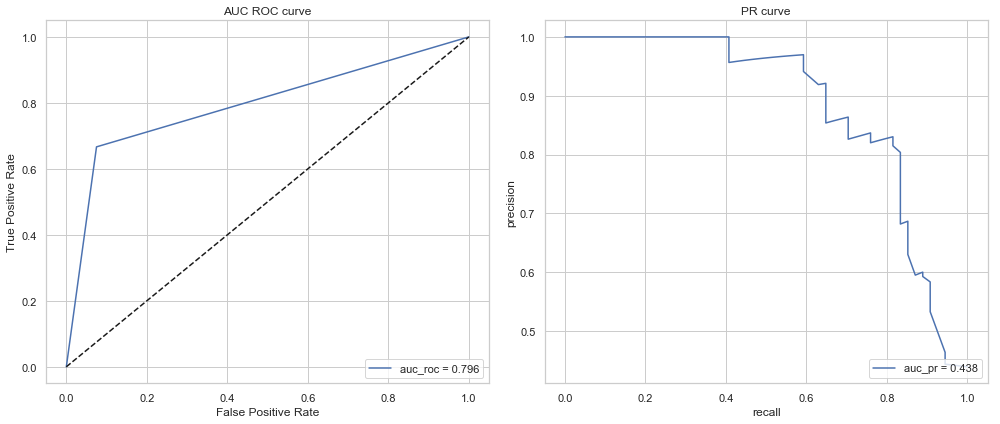

,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix
0,0.75,0.857143,0.666667,0.820896,0.795833,0.437814,"[[74, 6], [18, 36]]"


In [73]:
# XGBoost with Default Parameters

xgb = XGBClassifier(n_jobs = -1, random_state = 100)

xgb = xgb.fit(X_train.values, y_train.values.ravel())

# Get the Score Metrics and plots
scores = []

scores = get_scores(scores, xgb, X_test)

# Tabulate results
sampling_results = pd.DataFrame(scores, columns = ['f1', 'precision', 'recall', 'accuracy',
                                                   'auc_roc', 'auc_pr', 'confusion_matrix'])
sampling_results

## Hyperparameter Tuning for XGBoost

#### XGBoost - HyperTuning max_depth

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:   11.0s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:   16.7s
[Parallel(n_jobs=15)]: Done 180 out of 180 | elapsed:   18.5s finished


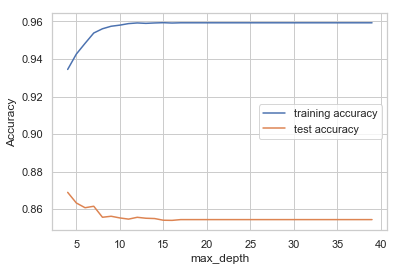

{'max_depth': 4}

In [74]:
# GridSearchCV to find optimal max_depth

xgb = XGBClassifier(n_jobs = -1, random_state = 100)

parameter = 'max_depth'

param_grid = {parameter: range(4, 40)}

gcv = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', xgb)
    
# scores of GridSearch CV
scores = gcv.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gcv.best_params_

#### XGBoost - HyperTuning learning_rate

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done  39 out of  45 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  45 out of  45 | elapsed:    0.9s finished


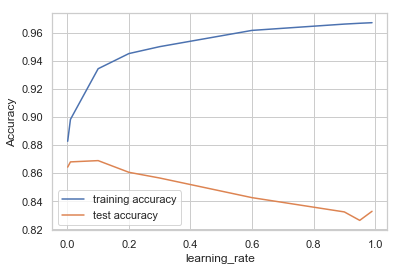

{'learning_rate': 0.1}

In [75]:
# GridSearchCV to find optimal learning_rate

xgb = XGBClassifier(max_depth = 4, n_jobs = -1, random_state = 100)

parameter = 'learning_rate'

param_grid = {parameter: [0.001, 0.01, 0.1, 0.2, 0.3, 0.6, 0.9, 0.95, 0.99]}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', xgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### XGBoost - HyperTuning n_estimators

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done  21 out of  50 | elapsed:    1.7s remaining:    2.4s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:    5.6s finished


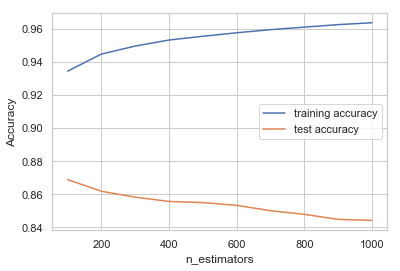

{'n_estimators': 100}

In [76]:
# GridSearchCV to find optimal n_estimators

xgb = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_jobs = -1, random_state = 100)

parameter = 'n_estimators'

param_grid = {parameter: range(100, 1100, 100)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', xgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### XGBoost - HyperTuning min_child_weight

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:    1.0s finished


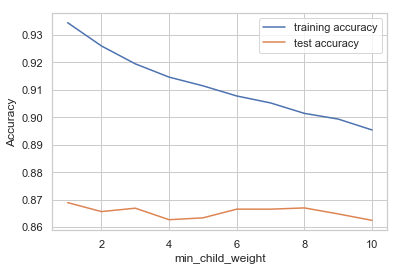

{'min_child_weight': 1}

In [77]:
# GridSearchCV to find optimal min_child_weight

xgb = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_estimators = 100, n_jobs = -1, random_state = 100)

parameter = 'min_child_weight'

param_grid = {parameter: range(1, 11)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', xgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### XGBoost - HyperTuning subsample

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  21 out of  50 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:    1.1s finished


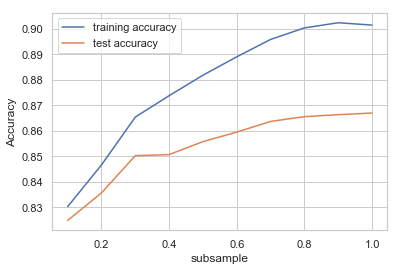

{'subsample': 1.0}

In [78]:
# GridSearchCV to find optimal subsample: 

xgb = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_estimators = 100, min_child_weight = 8,
                    n_jobs = -1, random_state = 100)

parameter = 'subsample'

param_grid = {parameter: np.arange(0.1, 1.1, 0.1)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', xgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### XGBoost - HyperTuning colsample_bytree

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  21 out of  50 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:    1.0s finished


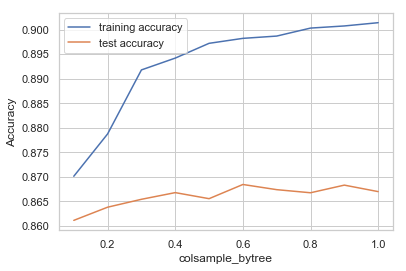

{'colsample_bytree': 0.6}

In [79]:
# GridSearchCV to find optimal colsample_bytree: 

xgb = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_estimators = 100, min_child_weight = 8,
                    subsample = 1.0, n_jobs = -1, random_state = 100)

parameter = 'colsample_bytree'

param_grid = {parameter: np.arange(0.1, 1.1, 0.1)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', xgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### Running the XGBoost with best parameters obtained from grid search - 

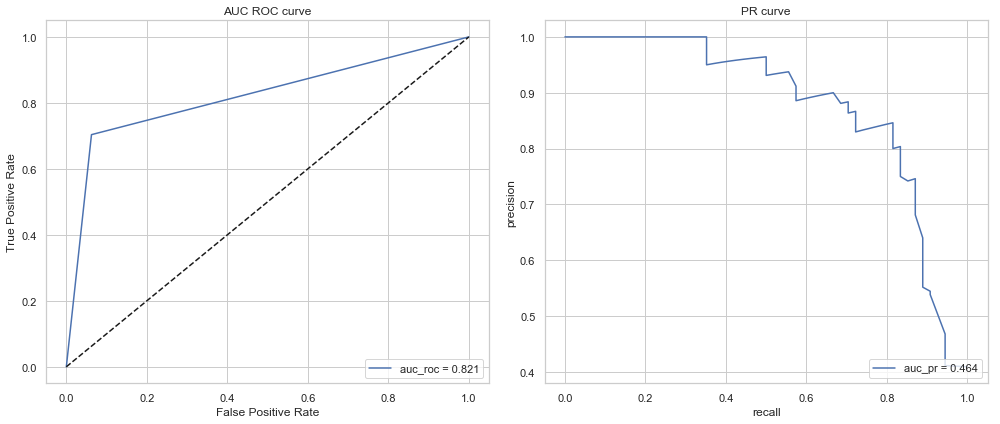

,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix
0,0.783505,0.883721,0.703704,0.843284,0.820602,0.463509,"[[75, 5], [16, 38]]"


In [80]:
# Random Forest with best parameters obtained from grid search

xgb = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_estimators = 100, min_child_weight = 8,
                    subsample = 1.0, colsample_bytree = 1.0, n_jobs = -1, random_state = 100)

xgb = xgb.fit(X_train.values, y_train.values.ravel())

# Get the Score Metrics and plots
scores = []

scores = get_scores(scores, xgb, X_test)

# Tabulate results
sampling_results = pd.DataFrame(scores, columns = ['f1', 'precision', 'recall', 'accuracy',
                                                   'auc_roc', 'auc_pr', 'confusion_matrix'])
sampling_results

## 2. LightGBM

### Running the LightGBM Classifier with default parameters.

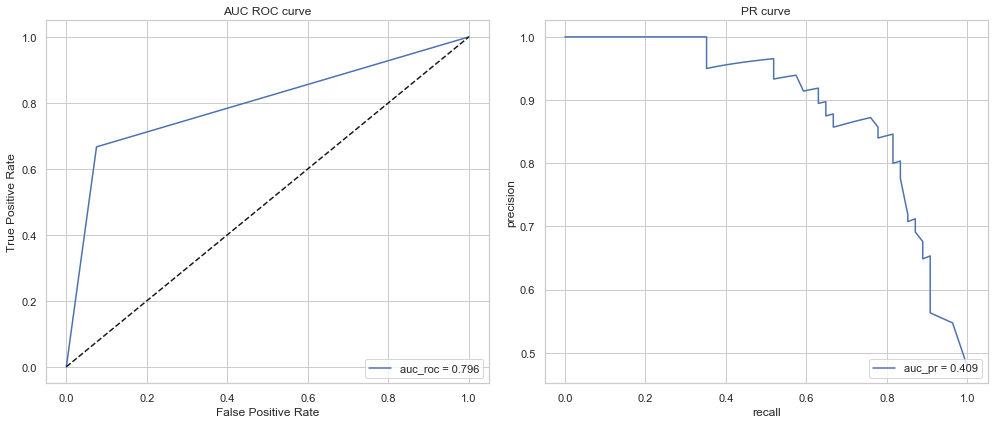

,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix
0,0.75,0.857143,0.666667,0.820896,0.795833,0.408894,"[[74, 6], [18, 36]]"


In [81]:
# LightGBM with Default Parameters

lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

lgb = lgb.fit(X_train.values, y_train.values.ravel())

# Get the Score Metrics and plots
scores = []

scores = get_scores(scores, lgb, X_test)

# Tabulate results
sampling_results = pd.DataFrame(scores, columns = ['f1', 'precision', 'recall', 'accuracy',
                                                   'auc_roc', 'auc_pr', 'confusion_matrix'])
sampling_results

## LightGBM - HyperTuning

#### LightGBM - HyperTuning num_leaves

Fitting 5 folds for each of 52 candidates, totalling 260 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 260 out of 260 | elapsed:    3.2s finished


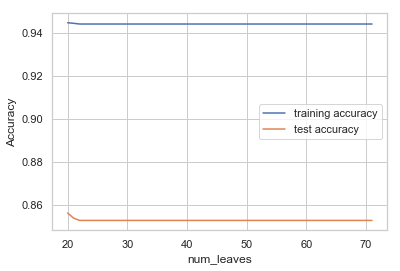

{'num_leaves': 20}

In [82]:
# GridSearchCV to find optimal num_leaves

lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

parameter = 'num_leaves'

param_grid = {parameter: range(20, 72)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', lgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### LightGBM - HyperTuning max_depth

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done 320 out of 320 | elapsed:    3.5s finished


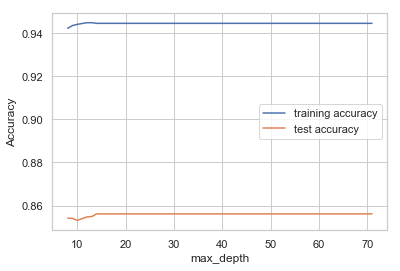

{'max_depth': 14}

In [83]:
# GridSearchCV to find optimal max_depth

lgb = LGBMClassifier(num_leaves = 20, objective = 'binary', n_jobs = -1, random_state = 100)

parameter = 'max_depth'

param_grid = {parameter: range(8, 72)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', lgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### LightGBM - HyperTuning learning_rate

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  21 out of  50 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:    0.4s finished


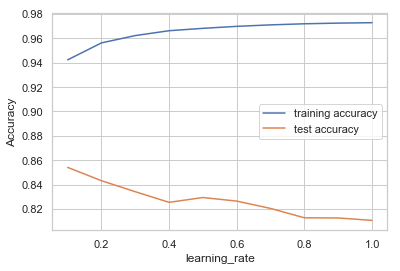

{'learning_rate': 0.1}

In [84]:
# GridSearchCV to find optimal learning_rate

lgb = LGBMClassifier(num_leaves = 20, max_depth = 8, objective = 'binary', n_jobs = -1, random_state = 100)

parameter = 'learning_rate'

param_grid = {parameter: np.arange(0.1, 1.1, 0.1)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', lgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### LightGBM - HyperTuning n_estimators

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  21 out of  50 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:    3.7s finished


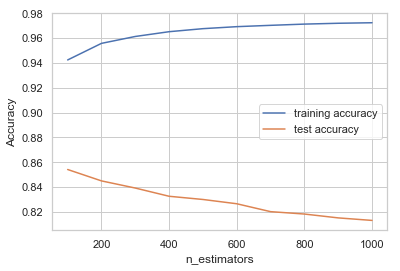

{'n_estimators': 100}

In [85]:
# GridSearchCV to find optimal n_estimators

lgb = LGBMClassifier(num_leaves = 20, max_depth = 8, learning_rate = 0.1, objective = 'binary',
                     n_jobs = -1, random_state = 100)

parameter = 'n_estimators'

param_grid = {parameter: range(100, 1100, 100)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', lgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### LightGBM - HyperTuning min_child_samples

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done 125 out of 125 | elapsed:    1.3s finished


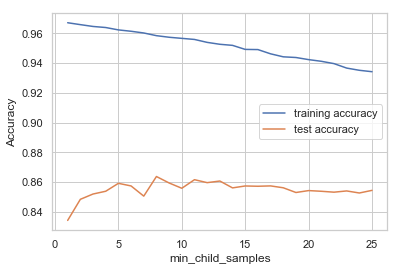

{'min_child_samples': 8}

In [86]:
# GridSearchCV to find optimal min_child_samples

lgb = LGBMClassifier(num_leaves = 20, max_depth = 8, learning_rate = 0.1, n_estimators = 100,
                     objective = 'binary', n_jobs = -1, random_state = 100)

parameter = 'min_child_samples'

param_grid = {parameter: range(1, 26)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', lgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### LightGBM - HyperTuning subsample¶

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  21 out of  50 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:    0.5s finished


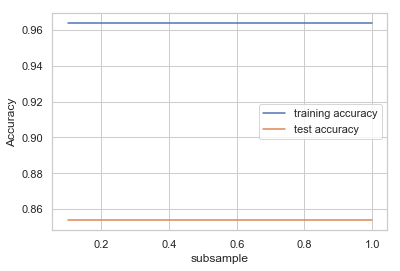

{'subsample': 0.1}

In [87]:
# GridSearchCV to find optimal subsample: 

lgb = LGBMClassifier(num_leaves = 20, max_depth = 8, learning_rate = 0.1, n_estimators = 100, min_child_samples = 4,
                     objective = 'binary', n_jobs = -1, random_state = 100)

parameter = 'subsample'

param_grid = {parameter: np.arange(0.1, 1.1, 0.1)}

gc = tune_hyper_parameter( X_train, y_train, param_grid, 'Individual', lgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### LightGBM - HyperTuning colsample_bytree

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  21 out of  50 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:    0.6s finished


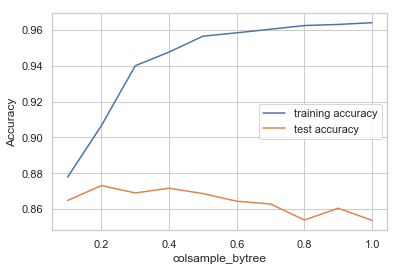

{'colsample_bytree': 0.2}

In [88]:
# GridSearchCV to find optimal colsample_bytree: 

lgb = LGBMClassifier(num_leaves = 20, max_depth = 8, learning_rate = 0.1, n_estimators = 100, min_child_samples = 4,
                     subsample = 0.1, objective = 'binary', n_jobs = -1, random_state = 100)

parameter = 'colsample_bytree'

param_grid = {parameter: np.arange(0.1, 1.1, 0.1)}

gc = tune_hyper_parameter(X_train, y_train, param_grid, 'Individual', lgb)
    
# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
hypertuning_plot(scores, parameter)

# Get the best value
gc.best_params_

#### Running the LightGBM with best parameters obtained from grid search - 

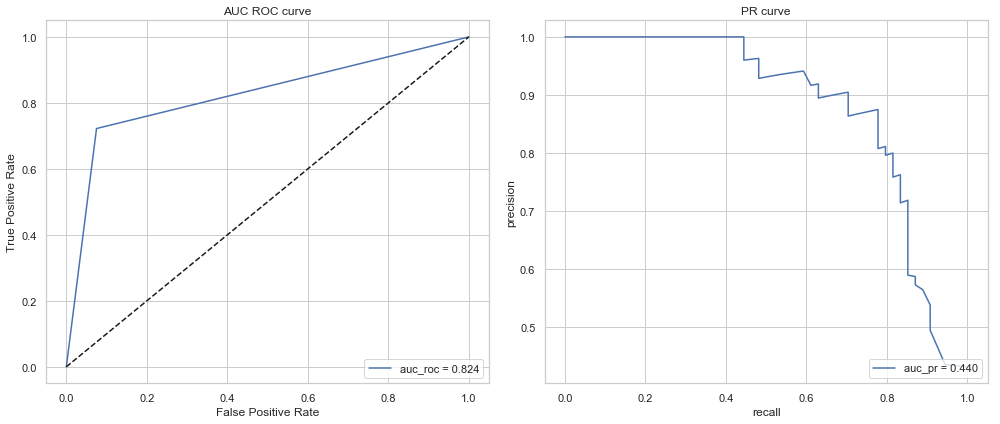

,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix
0,0.787879,0.866667,0.722222,0.843284,0.823611,0.439898,"[[74, 6], [15, 39]]"


In [89]:
# LightGBM with best parameters obtained from grid search

lgb = LGBMClassifier(num_leaves = 20, max_depth = 8, learning_rate = 0.1, n_estimators = 100, min_child_samples = 4,
                     subsample = 0.1, colsample_bytree = 0.2, objective = 'binary', n_jobs = -1, random_state = 100)

lgb = lgb.fit(X_train.values, y_train.values.ravel())

# Get the Score Metrics and plots
scores = []

scores = get_scores(scores, lgb, X_test)

# Tabulate results
sampling_results = pd.DataFrame(scores, columns = ['f1', 'precision', 'recall', 'accuracy',
                                                   'auc_roc', 'auc_pr', 'confusion_matrix'])
sampling_results

# Predictions

In [90]:
xgb_pred = xgb.predict(titanic_test_data.values)

xg_pred_file = pd.DataFrame({'PassengerId' : titanic_test_passengerId['PassengerId'],
                       'Survived': xgb_pred.T})
xg_pred_file.to_csv("submit_xg.csv", index=False)

In [91]:
lgb_pred = lgb.predict(titanic_test_data)

lg_pred_file = pd.DataFrame({'PassengerId' : titanic_test_passengerId['PassengerId'],
                       'Survived': lgb_pred.T})
lg_pred_file.to_csv("submit_lgbm.csv", index=False)